In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abtem
import ase
import dask

from helper_funcs import timeformat

In [2]:
#setting configuration
abtem.config.set({"device": "gpu", "fft": "fftw"})
dask.config.set({"num_workers": 1})

#! später noch:

- RINGSTRUKTUR hat noch fehler! -> radius erweitern o.Ä -> siehe foto

- struktur vergrößern (derzeit wieder 10x7 statt 20x20)
- grid_scan: start/ende erweitern

In [21]:
# Parameters and Settings
vacancy_atom = 'B' # enter 'N' for replacement of N-atom, or 'B' for replacement of B-atom
defect_atom_symbol = 'O' # symbol of impurity atom(s)
defect_type = 'ring' #'single'/'double'/'ring' for calculating potential etc with single/double defect or ring structure
lattice_constant = 2.504 # lattice constant for hBN, https://www.sciencedirect.com/science/article/abs/pii/S0025540815300088
size_x = 20 #size of structure
size_y = 13

#probe #!
energy_probe = 60e3
defocus = 0 # 0 or f.e.: 'scherzer'
semiangle_cutoff = 30 # maybe set to ctf crossover_angle, see below -> probe -> ctf? #!

#benchmark: Cs = -10e-6*1e10; astig = 10; coma = 1000; focal_spread = 10.0; angular_spread = 0.0
Cs = -10e-6*1e10 #spherical aberration; 10 micrometers
astig = 0 #25 aberration C12, ~few nanometers
astig_angle = 0 #+/-0.3 #rad
coma = 1500 #1000 aberration C21, ~few hundred nanometers
#focal_spread = 0.0
#angular_spread = 0.0

#------------------------------------------------------------------------------------------------------------------------------

#path
timestamp = timeformat()
path = (f'{timestamp}_hBN_size{size_x}x{size_y}_{defect_type}_vacany{vacancy_atom}_filledwith{defect_atom_symbol}_energy{int(energy_probe)}_defocus{defocus}_Cs{int(Cs)}_astig{astig}_astigangle{astig_angle}_coma{coma}')#_focal{int(focal_spread)}_ang{int(angular_spread)}')
print(path)

#variables total
variables_list = [timestamp, str(size_x) + 'x' + str(size_y), defect_type, vacancy_atom, defect_atom_symbol,
                 int(energy_probe), defocus, semiangle_cutoff, int(Cs), astig, astig_angle, coma]

20240903180224_hBN_size20x13_ring_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500


In [22]:
#create pd-dataframe/csv for overview -> only one time needed
#df = pd.DataFrame({'timestamp': timestamp, 'size': str(size_x) + 'x' + str(size_y), 'defect_type': defect_type,
#                   'vacancy_atom': vacancy_atom, 'defect_atom_symbol': defect_atom_symbol, 'energy_probe': int(energy_probe),
#                   'defocus':defocus,'semiangle_cutoff': semiangle_cutoff,'Spherical_abberation_CS': int(Cs),'astigmastism': astig, 
#                   'astigangle': astig_angle,'coma': coma},index = [0])
#df.to_csv('./data/data_overview.csv', index=False)

# Atomic structure & Manipulation

#### Structure

In [23]:
#create hBN cell
hBN_cell = ase.build.graphene(formula='BN', a=lattice_constant, thickness=0.0, size=(1, 1, 1), vacuum=2)

#orthogonalize cell and create structure
hBN_orth = abtem.orthogonalize_cell(hBN_cell)
hBN = hBN_orth*(size_x, size_y, 1) #!

#### Center Atoms

In [24]:
#find atoms located in the center
x_center = max(hBN.positions[:, 0])/2
y_center = max(hBN.positions[:, 1])/2

mask_center_position_x = ((hBN.positions[:,0] < x_center + lattice_constant)*
                          (hBN.positions[:,0] > x_center - lattice_constant))
mask_center_position_y = ((hBN.positions[:,1] < y_center + lattice_constant)*
                          (hBN.positions[:,1] > y_center - lattice_constant))
mask_center = mask_center_position_x * mask_center_position_y

center_indices = (np.asarray(np.where(mask_center == True)))[0]
center_indices.shape

(8,)

#### Assignments: Positions for Single and Double Defects, Ring Structure

In [25]:
#SINGLE: find index values in the middle of center index array to adress one (or two) specific atom(s)
ind = int(len(center_indices)/2 - 1) #center_indices.shape = (1,8);
ind_random = center_indices[ind]

#check if chosen atom is wanted single defect type and/or (re-)assign
if hBN.symbols[ind_random] == vacancy_atom:
    ind_single = ind_random
else:
    ind_single = center_indices[ind + 2]
    # +2 because Atoms are saved in the structure [... N N B B N N B...]

#for DOUBLE: make sure, the two atoms are neighbours
#find distance of next neighbours
nnd = round(hBN.get_distance(1, 3),4)

for index in center_indices:
    index_dist = round(hBN.get_distance(ind_single, index),4)
    if index_dist == nnd:
        #found next neighbour -> assign second index
        ind_double = [ind_single, index]
        break
    else:
        pass

#for RING:
#find distances of next neighbours, second neighbours (nnd_2) and third neighbors (nnd_3)
nnd = round(hBN.get_distance(1, 3),4)
nnd_2 = round(hBN.get_distance(1, 2),4)
nnd_3 = round(hBN.get_distance(0,2),4)#dist for atoms opposed to each other

#create dummy array for ring indices and assign first two possitions with double indices
ind_ring = [0 for i in range(6)]
ind_ring[0], ind_ring[1] = ind_double

#find atom opposite to first atom
for index in center_indices:
    dist_to_1 = round(hBN.get_distance(ind_ring[0], index),4)
    dist_to_2 = round(hBN.get_distance(ind_ring[1], index),4)

    if dist_to_1 == nnd_3 and dist_to_2 == nnd_2:
        ind_ring[3] = index #position 4
        break
    else:
        pass

#find remaining atoms (position numbering 1 to 6 counterclockwise): 
for index in center_indices:
    dist_to_1 = round(hBN.get_distance(ind_ring[0], index),4)
    dist_to_2 = round(hBN.get_distance(ind_ring[1], index),4)
    dist_to_4 = round(hBN.get_distance(ind_ring[3], index),4)
    if dist_to_1 == nnd_2 and dist_to_2 == nnd and dist_to_4 == nnd:
        ind_ring[2] = index #position 3
    if dist_to_1 == nnd_2 and dist_to_2 == nnd_3 and dist_to_4 == nnd:
        ind_ring[4] = index #position 5
    if dist_to_1 == nnd and dist_to_2 == nnd_2 and dist_to_4 == nnd_2:
        ind_ring[5] = index #position 6 
    else:
        pass

print(f'Center indices: {center_indices}')
print(f'Chosen index single: {ind_single}')
print(f'Chosen index double: {ind_double}')
print(f'Chosen index ring: {ind_ring}')

Center indices: [492 493 494 495 544 545 546 547]
Chosen index single: 495
Chosen index double: [495, 493]
Chosen index ring: [495, 493, 544, 545, 547, 546]


#### Impurities

In [26]:
#insert impurity atoms - introducing single and double defects
hBN_single = hBN.copy()
hBN_double = hBN.copy()
hBN_ring = hBN.copy()

hBN_single.symbols[ind_single] = defect_atom_symbol
hBN_double.symbols[ind_double] = defect_atom_symbol
hBN_ring.symbols[ind_ring] = defect_atom_symbol

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

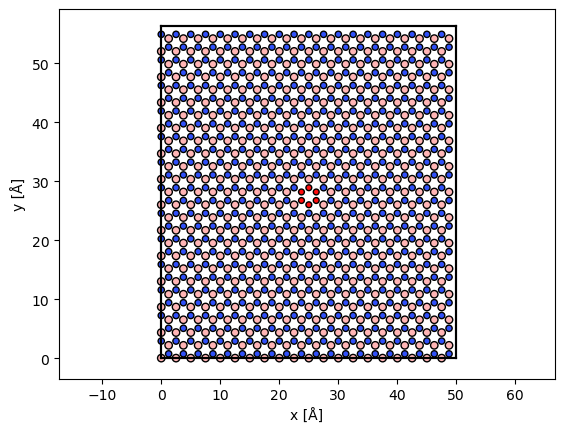

In [27]:
#show
#abtem.show_atoms(hBN_center, numbering=True, merge=False)
hBN_ring.symbols[ind_ring] = 'O'
#hBN_ring.symbols[center_indices] = 'S'
#hBN_ring.symbols[ind_double] = 'C'
abtem.show_atoms(hBN_ring)

# Potential

In [28]:
#RUN BEFORE CALCULATING POTENTIAL
if defect_type == 'double':
    hBN_manipulated = hBN_double
elif defect_type == 'single':
    hBN_manipulated = hBN_single
elif defect_type == 'ring':
    hBN_manipulated = hBN_ring
else:
    raise KeyboardInterrupt

hBN_manipulated

Atoms(symbols='B517N517O6', pbc=[True, True, False], cell=[50.08, 56.38171788798209, 4.0])

In [29]:
#implement frozen phonons (average of random offset-snapshots)
frozen_phonons = abtem.FrozenPhonons(hBN_manipulated, num_configs=10, sigmas=0.1) #! num_configs

In [30]:
#create potential (sampling = physical extent/ gridpoints), slice thickness not usefull - no layers
potential = abtem.Potential(frozen_phonons, sampling=0.05)
potential.shape

(10, 4, 1002, 1128)

In [31]:
#potential.build().compute()

# Probe

In [32]:
#consider partial temporal coherence (due to energy spread of probe) by building gaussian distributed defocus series
#focal_spread = focal_spread
#defocus_distribution = abtem.distributions.gaussian(center=0.0, standard_deviation=focal_spread, num_samples=11,
#                                                    sampling_limit=2, ensemble_mean=False,)
#condider partial spacial coherence (due to source size)
#angular_spread = angular_spread

#create probe and insert parameters for abberations (ctf)
#aberration_coefficients = {'C10': defocus_distribution, 'C30': Cs, 'C12': astig, 'C21': coma}

aberration_coefficients = {'C10': defocus, 'C30': Cs, 'C12': astig, 'C21': coma}

In [33]:
probe = abtem.Probe(energy=energy_probe, semiangle_cutoff=semiangle_cutoff, aberrations=aberration_coefficients, astigmatism_angle=astig_angle) #maybe use crossover angle of ctf for semiangle_cutoff? #!
probe.grid.match(potential)
probe.sampling

(0.04998003992015968, 0.04998379245388483)

In [34]:
probe.build().compute()

[########################################] | 100% Completed | 312.41 ms


# Scan & Detect

In [35]:
#choose Nyquist sampling for scan
sampling = probe.aperture.nyquist_sampling
print(f'Nyquist sampling: {sampling:.3f} Å/pixel')

Nyquist sampling: 0.406 Å/pixel


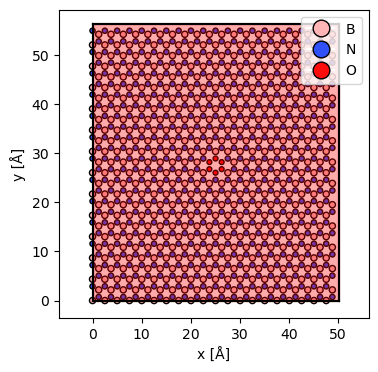

In [36]:
#setup for grid scan
#gridscan = abtem.GridScan(start=[3.5/10, 4/10], end=[6/10, 6/10], fractional = True,
#                     potential=potential, sampling=sampling) 
gridscan = abtem.GridScan(start=[0, 0], end=[10/10, 10/10], fractional = True,
                     potential=potential, sampling=sampling) #!

fig, ax = abtem.show_atoms(hBN_manipulated, figsize=(4,4), legend=True)
gridscan.add_to_plot(ax)

In [70]:
#setup detectors
detector_maadf = abtem.AnnularDetector(inner=60, outer=200)

In [71]:
#apply scan & detectors
measurements_total = probe.scan(potential, scan=gridscan, detectors=detector_maadf)

# Export & Import

In [13]:
#compute and EXPORT... 
#measurements_total.to_zarr(f'./data/{path}_RAW.zarr')

#and/or IMPORT from file
#imported_measurements = abtem.from_zarr(f'./data/{path}_RAW.zarr')

#imported_measurements = abtem.from_zarr(f'./data/RAW_{path_old}.zarr')
imported_measurements = abtem.from_zarr('./data/20240903175046_hBN_size5x3_single_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma0_RAW.zarr').compute()
#imported_measurements = abtem.from_zarr('./data/20240808140959_hBN_size10x7_single_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig10_coma1000_RAW.zarr').compute()

[########################################] | 100% Completed | 102.22 ms


In [83]:
#add to overview dataframe by appending new row with df.loc[index]
df = pd.read_csv('./data/data_overview.csv')
df.loc[len(df.index)] = [value for value in variables_list]
df.to_csv('./data/data_overview.csv')
df.tail()

#df.drop(index=1) -> delete entry; df.iloc[index_row, index_col] -> adress row/col, df.iat[.,.] -> adress single item

,timestamp,size,defect_type,vacancy_atom,defect_atom_symbol,energy_probe,defocus,semiangle_cutoff,Spherical_abberation_CS,astigmastism,astigangle,coma
0,20240902131243,10x7,single,B,O,60000,0,30,-100000,0,0,1500


# Postprocessing

In [14]:
#set parameters for postprocessing
#pairs: interpolate:0.01 & gauss: 0.2;  interpolate:0.05 & gauss: 0.3
#interpolate-> higher value (0.1) more pixels; low value -> smoother, more time
interpolate = 0.01
gauss = 0.3
dose = 1e9
#interpol war 0.02; gauss 0.1
#interpol war 0.01; gauss 0.3

path_final = (f'{path}_interpol{interpolate}_gauss{gauss}_dose{int(dose)}')
#path_final = (f'{path_old}_interpol{interpolate}_gauss{gauss}_dose{dose}') #-> for multiple postprocessing versions
print(path_final)

20240903175516_hBN_size20x13_ring_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500_interpol0.01_gauss0.3_dose1000000000


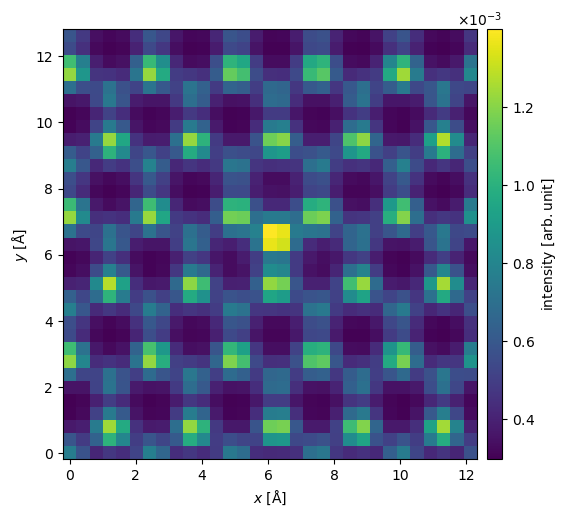

In [15]:
#assign detectors
maadf_measurement = imported_measurements#.integrate_radial(60, 200)

#..and plot
measurements = maadf_measurement
measurements.show(figsize=(14, 5), cbar=True,);

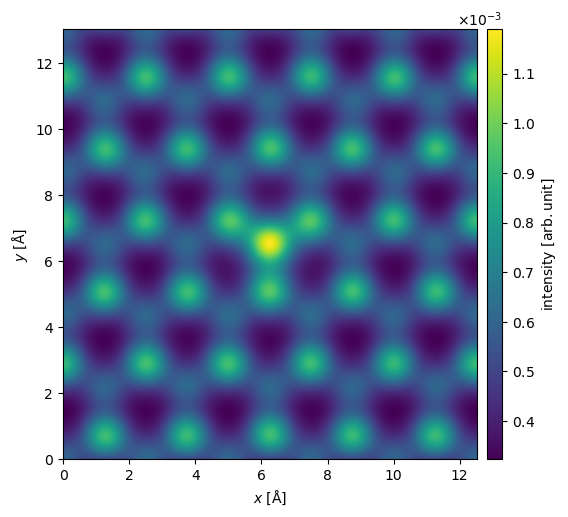

In [16]:
#interpolate to smooth images and apply gaussian filter to consider partial spatial coherence 
final_measurements = measurements.interpolate(interpolate).gaussian_filter(gauss)

#plot
final_measurements.show(explode=True, figsize=(14, 5), cbar=True)

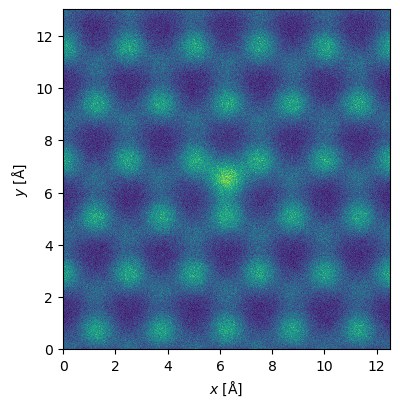

In [17]:
#noise to account for finite electrone dose -> statistic deviation (see abtem walkthrough -> scan & detect)

noisy_measurements = final_measurements.poisson_noise(dose_per_area=dose, seed=100)
noisy_measurements.show(explode=True, figsize=(12, 4))

#zoom in
#plt.xlim(0,2)
#plt.ylim(0,2)

In [18]:
#export
noisy_measurements.to_zarr(f'./data/{path_final}_FINAL.zarr')
#noisy_measurements.to_zarr(f'./data/FINAL2_{path_old}.zarr')

[########################################] | 100% Completed | 102.17 ms


[[None]]

[########################################] | 100% Completed | 104.46 ms


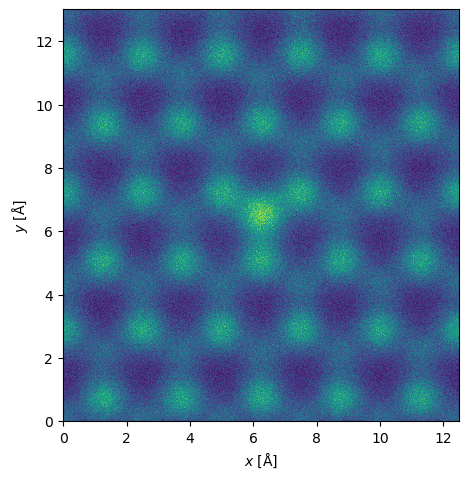

In [19]:
import_new = abtem.from_zarr(f'./data/{path_final}_FINAL.zarr')
import_new.show(explode=True)

In [20]:
#reassign path variable to avoid overwriting
path_old = path
path_final_old = path_final
#create new path variable
timestamp = timeformat()
path = (f'{timestamp}_hBN_size{size_x}x{size_y}_{defect_type}_vacany{vacancy_atom}_filledwith{defect_atom_symbol}_energy{int(energy_probe)}_defocus{defocus}_Cs{int(Cs)}_astig{astig}_astigangle{astig_angle}_coma{coma}')#_focal{int(focal_spread)}_ang{int(angular_spread)}')
path_final = (f'{path}_interpol{interpolate}_gauss{gauss}_dose{dose}')

print(path_old)
print(path)

20240903175516_hBN_size20x13_ring_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500
20240903175659_hBN_size20x13_ring_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500
